# Predictive Maintenance of machines

## Data Information

### Source

The notebook is based on a predictive maintenance use case from the energy industry. The data is downloaded from Microsoft Azure [MLWorkshop](https://github.com/microsoft/AMLWorkshop) <br>
The input data are simulated (and simplified) telemetry and machine log readings from a hydropower turbine.The goal is to create an interpretable classification model that can predict the turbine failure. Specifically, whether the turbine will experience a component failure in the 24 hours following the given telemetry and error reading.

### Data files

The data comes from 4 different sources which are:
    
- real-time telemetry data collected from machines 
- error messages
- failure history
- machine information such as type and age

## Notebook setup

In [1]:
#Common imports
import sys
import os
import numpy as np

#Python Data Analysis Library
import pandas as pd

#Data visualization
%matplotlib inline 
#sets the backend of matplotlib to the 'inline' backend
#%matplotlib notebook
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#Data pretty printer
from pprint import pprint

## Data import and cleaning

### Telemetry data

#### Data import

In [2]:
telemetry = pd.read_csv('datasets/machine_predictive_maintenance/telemetry.csv')

#### Data discovery

In [3]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,1/1/2015 6:00:00 AM,1,176.217853,418.504078,113.077935,45.087686
1,1/1/2015 7:00:00 AM,1,162.879223,402.747490,95.460525,43.413973
2,1/1/2015 8:00:00 AM,1,170.989902,527.349825,75.237905,34.178847
3,1/1/2015 9:00:00 AM,1,162.462833,346.149335,109.248561,41.122144
4,1/1/2015 10:00:00 AM,1,157.610021,435.376873,111.886648,25.990511


In [4]:
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
datetime     876100 non-null object
machineID    876100 non-null int64
volt         876100 non-null float64
rotate       876100 non-null float64
pressure     876100 non-null float64
vibration    876100 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB


In [5]:
telemetry.datetime = pd.to_datetime(telemetry.datetime, format = ("%m/%d/%Y %I:%M:%S %p"))

In [6]:
telemetry.machineID = telemetry.machineID.astype('category')

In [7]:
telemetry.machineID.value_counts()

100    8761
37     8761
27     8761
28     8761
29     8761
30     8761
31     8761
32     8761
33     8761
34     8761
35     8761
36     8761
38     8761
99     8761
39     8761
40     8761
41     8761
42     8761
43     8761
44     8761
45     8761
46     8761
47     8761
48     8761
26     8761
25     8761
24     8761
23     8761
2      8761
3      8761
       ... 
95     8761
96     8761
97     8761
98     8761
77     8761
75     8761
52     8761
74     8761
53     8761
54     8761
55     8761
56     8761
57     8761
58     8761
59     8761
60     8761
61     8761
62     8761
63     8761
64     8761
65     8761
66     8761
67     8761
68     8761
69     8761
70     8761
71     8761
72     8761
73     8761
1      8761
Name: machineID, Length: 100, dtype: int64

We have 100 different machines and they all have 8761 observations each.

Time series start and end

In [8]:
telemetry.sort_values(by='datetime').iloc[0,0]

Timestamp('2015-01-01 06:00:00')

In [9]:
nrow = len(telemetry)-1
telemetry.sort_values(by='datetime').iloc[nrow,0]

Timestamp('2016-01-01 06:00:00')

We can see that we have time series of the data as 1 year with hourly aggregates data. Technically this would have total observations as:

In [10]:
print(365*24)

8760


As we have 8761 observations, it aligns with the timelines perfectly and we have complete cycle data.

#### Descriptive statistics

In [11]:
telemetry.describe()

,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000
mean,170.777736,446.605119,100.858668,40.385007
std,15.509114,52.673886,11.048679,5.370361
min,97.333604,138.432075,51.237106,14.877054
25%,160.304927,412.305714,93.498181,36.777299
50%,170.607338,447.558150,100.425559,40.237247
75%,181.004493,482.176600,107.555231,43.784938
max,255.124717,695.020984,185.951998,76.791072


#### Data Visualization 

We will try to visualize data for 2 different machines and assume rest of them are operating in a similar trend.

##### Time series plots

In [12]:
def individual_timeseries_plot(data,col_name,date_col):
    import matplotlib.dates as mdates
    tick_unit = mdates.MonthLocator()  # every day
    tick_fmt = mdates.DateFormatter('%m')
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()
    fig, ax = plt.subplots()
    fig = sns.lineplot(x = date_col, y = col_name, data = data)
    ax.xaxis.set_major_locator(tick_unit)
    ax.xaxis.set_major_formatter(tick_fmt)

In [13]:
def multiple_plots_ts(data,df_numeric,date_col):
    n = len(df_numeric)
    for i in range(1,n+1):
        col_name = df_numeric[i-1]
        individual_timeseries_plot(data,col_name,date_col)
    return  

**Machine ID = 1**

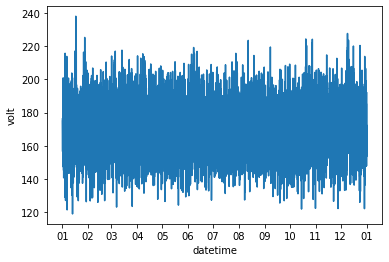

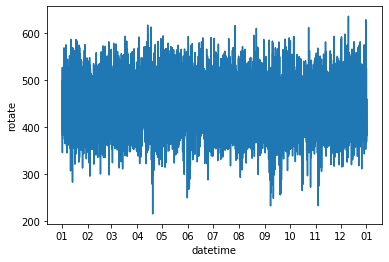

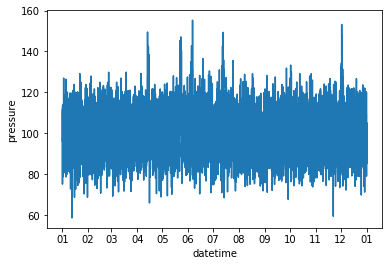

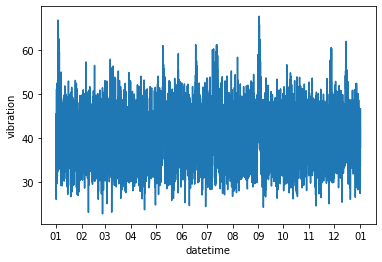

In [14]:
multiple_plots_ts(telemetry[telemetry.machineID == 1],
                  ['volt', 'rotate', 'pressure', 'vibration'],
                  'datetime')

**Machine ID = 2**

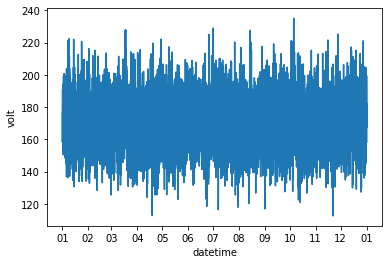

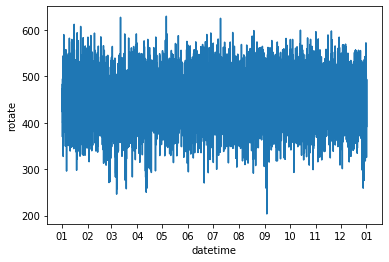

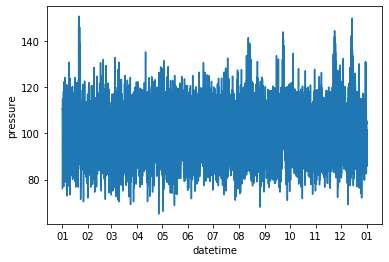

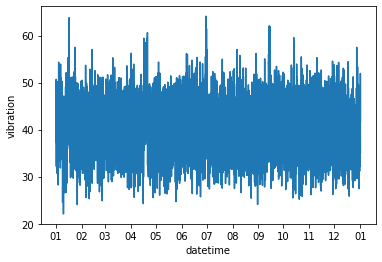

In [15]:
multiple_plots_ts(telemetry[telemetry.machineID == 2],
                  ['volt', 'rotate', 'pressure', 'vibration'],
                  'datetime')

##### Histograms

In [16]:
def hist_plots(data, numeric,col_no):
    data_fig = pd.melt(data, value_vars= numeric)
    fig = sns.FacetGrid(data_fig, col = "variable", col_wrap = col_no,sharex= False, sharey = False)
    fig = fig.map(sns.distplot, "value", color = 'c')
    return fig
#col_no : number of columns to display in one row
#numeric : name of numeric cols

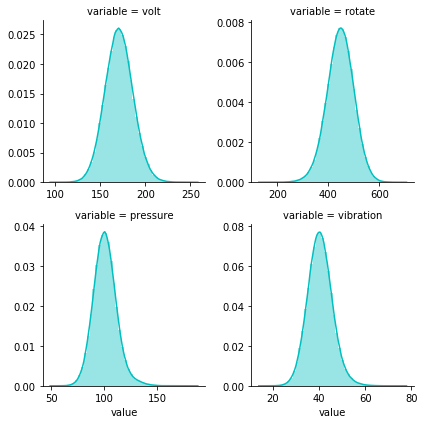

In [17]:
hist_plots(telemetry,
          ['volt', 'rotate', 'pressure', 'vibration'],2)

Thus, we see a normal distribution of telemetry variables with evident similarities between different machines.

#### Machines data

In [18]:
machines = pd.read_csv('datasets/machine_predictive_maintenance/machines.csv')

In [19]:
machines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
machineID    100 non-null int64
model        100 non-null object
age          100 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.4+ KB


In [20]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [21]:
machines.machineID = machines.machineID.astype('category')
machines.model = machines.model.astype('category')

In [22]:
machines.model.value_counts()

model3    35
model4    32
model2    17
model1    16
Name: model, dtype: int64

This file has meta data relating to the machines.

#### Errors data

In [23]:
errors = pd.read_csv('datasets/machine_predictive_maintenance/errors.csv')

In [24]:
errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
datetime     3919 non-null object
machineID    3919 non-null int64
errorID      3919 non-null object
dtypes: int64(1), object(2)
memory usage: 91.9+ KB


In [25]:
errors.head()

,datetime,machineID,errorID
0,1/3/2015 7:00:00 AM,1,error1
1,1/3/2015 8:00:00 PM,1,error3
2,1/4/2015 6:00:00 AM,1,error5
3,1/10/2015 3:00:00 PM,1,error4
4,1/22/2015 10:00:00 AM,1,error4


In [26]:
errors.datetime = pd.to_datetime(errors.datetime, format = ("%m/%d/%Y %I:%M:%S %p"))

In [27]:
errors.machineID = errors.machineID.astype('category')
errors.errorID = errors.errorID.astype('category')

In [28]:
errors.errorID.value_counts()

error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

This dataset as errors with date time and machine ID. These are non-breaking errors thrown while the machine is still operational and do not constitute as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

#### Failures data

In [29]:
failures = pd.read_csv('datasets/machine_predictive_maintenance/failures.csv')

In [30]:
failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 2 columns):
datetime     719 non-null object
machineID    719 non-null int64
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


In [31]:
failures.head()

,datetime,machineID
0,1/5/2015 6:00:00 AM,1
1,3/6/2015 6:00:00 AM,1
2,4/20/2015 6:00:00 AM,1
3,6/19/2015 6:00:00 AM,1
4,9/2/2015 6:00:00 AM,1


In [32]:
failures.datetime = pd.to_datetime(failures.datetime, format = ("%m/%d/%Y %I:%M:%S %p"))

In [33]:
failures.machineID = failures.machineID.astype('category')

Text(0.5, 1.01, 'Failures per machine ID')

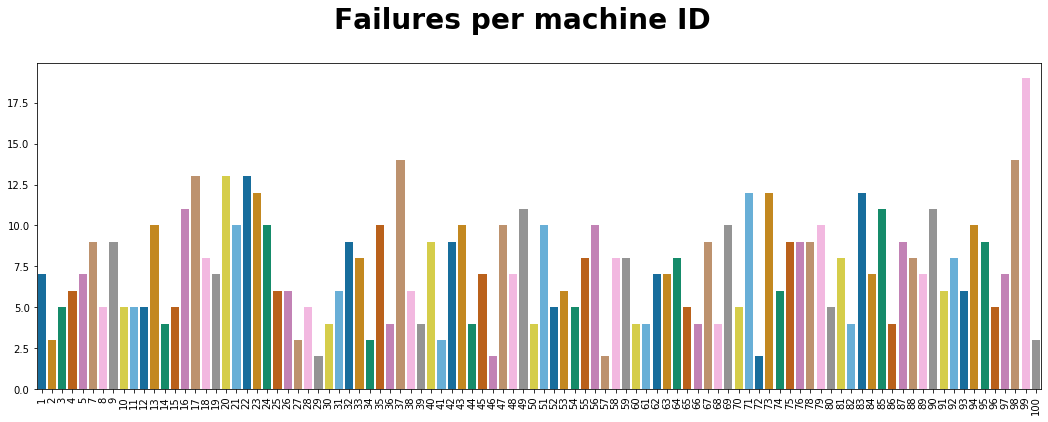

In [34]:
fig, (ax) = plt.subplots(1, 1, figsize=(18, 6))

sns.barplot(x = np.array(failures.machineID.value_counts().index),
            y = np.array(failures.machineID.value_counts()),
           palette="colorblind")

plt.xticks(rotation='vertical')

plt.suptitle('Failures per machine ID',
            y = 1.01,
            fontsize = 28,
            fontweight = 'bold')

## Feature engineering

Telemetry data almost always comes with time-stamps which makes it suitable for calculating lagging features. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window. In this notebook, we want to calculate rolling mean and standard deviation of the telemetry data over the last 24 hour lag window, calculated for every 3 hours.

Similar to telemetry, errors also come with time-stamps. However, unlike telemetry that had numerical values, errors have categorical values denoting the type of error that occured at a time-stamp. In this case, aggregating methods such as averaging does not apply. Counting the different categories is a more viable approach where lagging counts of different types of errors that occured in the lag window are calculated. 

The machine features are used directly as they hold descriptive information about the type of the machines and their ages which is the years in service.

When using classification for predicting failure due to a problem, labeling is done by taking a time window prior to the failure of an asset and labeling the feature records that fall into that window as about to fail due to a problem while labeling all other records as normal. This time window should be picked according to the business case where in some situations it may be enough to predict failures hours in advance while in others days or weeks maybe needed to allow for the arrival of parts to be replaced as an example.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a component failure. 

Labelling is done by labeling all the feature records that fall into the 24 hours window before a failure as TRUE.The rest of the records are labeled as FALSE indicating, there is no failure within the next 24 hour

In [35]:
df = pd.read_csv('datasets/machine_predictive_maintenance/features.csv')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291300 entries, 0 to 291299
Data columns (total 18 columns):
datetime         291300 non-null object
machineID        291300 non-null int64
voltmean         291300 non-null float64
rotatemean       291300 non-null float64
pressuremean     291300 non-null float64
vibrationmean    291300 non-null float64
voltsd           291300 non-null float64
rotatesd         291300 non-null float64
pressuresd       291300 non-null float64
vibrationsd      291300 non-null float64
error1count      291300 non-null float64
error2count      291300 non-null float64
error3count      291300 non-null float64
error4count      291300 non-null float64
error5count      291300 non-null float64
model            291300 non-null object
age              291300 non-null int64
failure          291300 non-null bool
dtypes: bool(1), float64(13), int64(2), object(2)
memory usage: 38.1+ MB


In [37]:
df.head()

,datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,model,age,failure
0,2015-01-02T05:00:00Z,1,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209,0.0,0.0,0.0,0.0,0.0,model3,18,False
1,2015-01-02T08:00:00Z,1,170.525721,443.906847,97.667249,39.786670,12.591948,46.930282,9.406795,6.098173,0.0,0.0,0.0,0.0,0.0,model3,18,False
2,2015-01-02T11:00:00Z,1,170.049722,446.461279,96.906162,40.016513,13.277336,42.836780,9.071472,5.481724,0.0,0.0,0.0,0.0,0.0,model3,18,False
3,2015-01-02T14:00:00Z,1,170.341974,447.355315,96.229522,39.921963,13.817158,42.808633,8.256794,5.862312,0.0,0.0,0.0,0.0,0.0,model3,18,False
4,2015-01-02T17:00:00Z,1,170.060643,452.163407,96.357441,39.990470,14.792869,42.525293,8.669605,5.907157,0.0,0.0,0.0,0.0,0.0,model3,18,False


In [38]:
df.datetime = pd.to_datetime(df.datetime)

In [39]:
df.model = df.model.astype('category')

In [40]:
df.head()

,datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,model,age,failure
0,2015-01-02 05:00:00+00:00,1,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209,0.0,0.0,0.0,0.0,0.0,model3,18,False
1,2015-01-02 08:00:00+00:00,1,170.525721,443.906847,97.667249,39.786670,12.591948,46.930282,9.406795,6.098173,0.0,0.0,0.0,0.0,0.0,model3,18,False
2,2015-01-02 11:00:00+00:00,1,170.049722,446.461279,96.906162,40.016513,13.277336,42.836780,9.071472,5.481724,0.0,0.0,0.0,0.0,0.0,model3,18,False
3,2015-01-02 14:00:00+00:00,1,170.341974,447.355315,96.229522,39.921963,13.817158,42.808633,8.256794,5.862312,0.0,0.0,0.0,0.0,0.0,model3,18,False
4,2015-01-02 17:00:00+00:00,1,170.060643,452.163407,96.357441,39.990470,14.792869,42.525293,8.669605,5.907157,0.0,0.0,0.0,0.0,0.0,model3,18,False


## Model Development

### Pre processing of data

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['failure','datetime'],axis = 1), 
                                                    df.failure,
                                                    test_size=0.3, 
                                                    random_state=101,
                                                   stratify = df.failure)

In [42]:
len(y_test)

87390

In [43]:
y_test.value_counts()

False    85711
True      1679
Name: failure, dtype: int64

In [44]:
len(y_train)

203910

In [45]:
y_train.value_counts()

False    199994
True       3916
Name: failure, dtype: int64

In [46]:
numeric = list(X_train.select_dtypes(include=['float64','int64']).columns)

num = pd.DataFrame(data = X_train[numeric], columns = numeric)
num.head()

,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,age
226210,78,169.603121,435.866267,99.353835,39.354539,13.907853,49.157826,10.551821,5.521463,0.0,0.0,0.0,0.0,0.0,19
43599,15,174.098133,437.115580,97.172119,39.516531,13.290625,42.021714,10.844448,5.248578,0.0,0.0,0.0,0.0,0.0,14
285947,99,172.403893,461.368148,102.162942,39.308661,13.023697,50.831278,16.081346,5.941171,0.0,0.0,0.0,0.0,0.0,14
186000,64,168.333802,444.832976,96.488187,41.060720,15.697274,58.017486,12.281689,6.253771,0.0,0.0,0.0,0.0,0.0,20
170595,59,174.526207,459.267577,101.003753,42.390524,18.086897,35.745002,11.864469,4.092209,0.0,0.0,0.0,0.0,0.0,17


In [47]:
categorical = list(X_train.select_dtypes(include=['category','bool']).columns)

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(X_train[categorical])
cat = pd.DataFrame(encoder.transform(X_train[categorical]).toarray(),columns = encoder.get_feature_names())

cat.index = num.index #ensuring consistent index for join operation

cat.head()

,x0_model1,x0_model2,x0_model3,x0_model4
226210,0.0,0.0,0.0,1.0
43599,0.0,0.0,1.0,0.0
285947,1.0,0.0,0.0,0.0
186000,0.0,0.0,1.0,0.0
170595,0.0,0.0,1.0,0.0


In [48]:
X_train_pre = num.merge(cat, left_on=num.index, right_on= cat.index).drop(['key_0'],axis = 1)

In [49]:
X_train_pre.shape

(203910, 19)

In [50]:
num = pd.DataFrame(data = X_test[numeric], columns = numeric)
cat = pd.DataFrame(encoder.transform(X_test[categorical]).toarray(),columns = encoder.get_feature_names())
cat.index = num.index #ensuring consistent index for join operation
X_test_pre = num.merge(cat, left_on=num.index, right_on= cat.index).drop(['key_0'],axis = 1)
X_test_pre.head()

,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,age,x0_model1,x0_model2,x0_model3,x0_model4
0,38,171.757660,446.585867,100.548160,39.901826,11.704299,40.210692,11.867209,4.193405,0.0,0.0,0.0,0.0,0.0,15,0.0,0.0,0.0,1.0
1,92,171.423774,461.885769,123.734848,39.180705,17.456089,56.439428,11.730363,4.882756,0.0,0.0,0.0,0.0,0.0,2,1.0,0.0,0.0,0.0
2,12,169.320701,450.610137,99.326845,39.619170,17.097052,40.197812,10.461020,4.481677,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,1.0,0.0
3,99,167.970800,461.197675,98.259396,38.436493,14.564515,47.154429,11.030687,5.419963,0.0,0.0,0.0,0.0,0.0,14,1.0,0.0,0.0,0.0
4,84,171.257014,445.224971,99.332250,41.629605,14.345048,47.232030,9.719112,5.388935,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,1.0,0.0


### XGBoost algorithm

In [51]:
import xgboost as xgb

In [52]:
%%time

xgb_clf =xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=101)

xgb_clf.fit(X_train_pre,y_train)

Wall time: 3min 27s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#### Out of sample predictions

In [53]:
y_pred = xgb_clf.predict(X_test_pre)

#### Confusion Matrix

In [54]:
df_demo = {'y_Predicted': list((y_pred > 0.5)),
        'y_Actual':    list(y_test) }
df_cm = pd.DataFrame(df_demo, columns=['y_Actual','y_Predicted'])
pd.crosstab(df_cm['y_Actual'], df_cm['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

Predicted,False,True
Actual,,
False,85680,31
True,11,1668


#### Model accuracy

In [55]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.values, (y_pred > 0.5))

0.9995193958118778

#### Classification report

In [56]:
from sklearn.metrics import classification_report

target_names = ['True', 'False']
print(classification_report(y_test.values, (y_pred > 0.5), 
                            target_names=target_names))

              precision    recall  f1-score   support

        True       1.00      1.00      1.00     85711
       False       0.98      0.99      0.99      1679

    accuracy                           1.00     87390
   macro avg       0.99      1.00      0.99     87390
weighted avg       1.00      1.00      1.00     87390



## Interpretation of model

### Feature importance through sklearn 

In [57]:
feature_importances = pd.DataFrame(xgb_clf.feature_importances_,
                                   index = X_train_pre.columns,
                                    columns=['importance']).sort_values('importance', 
                                                                        ascending=False)
feature_importances

,importance
error2count,0.344574
error3count,0.179816
error5count,0.147687
error1count,0.081648
voltmean,0.056921
pressuremean,0.050357
error4count,0.048520
vibrationmean,0.041559
x0_model3,0.011616
x0_model4,0.009857


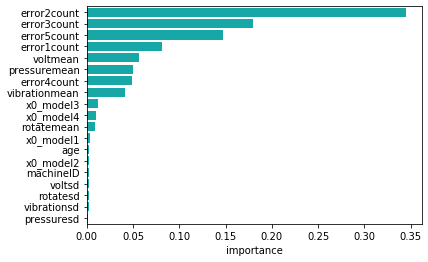

In [58]:
sns.barplot(x='importance', y=feature_importances.index, 
            data=feature_importances, color="c")

### Feature importance through XGBoost

The model enables us to view feature importances based on the following.

- Feature Weights: This is based on the number of times a feature appears in a tree across the ensemble of trees
- Gain: This is based on the average gain of splits which use the feature
- Coverage: This is based on the average coverage (number of samples affected) of splits which use the feature

Note that they all contradict each other, which motivates the use of model interpretation frameworks like SHAP which uses something known as SHAP values, which claim to come with consistency guarantees (meaning they will typically order the features correctly).

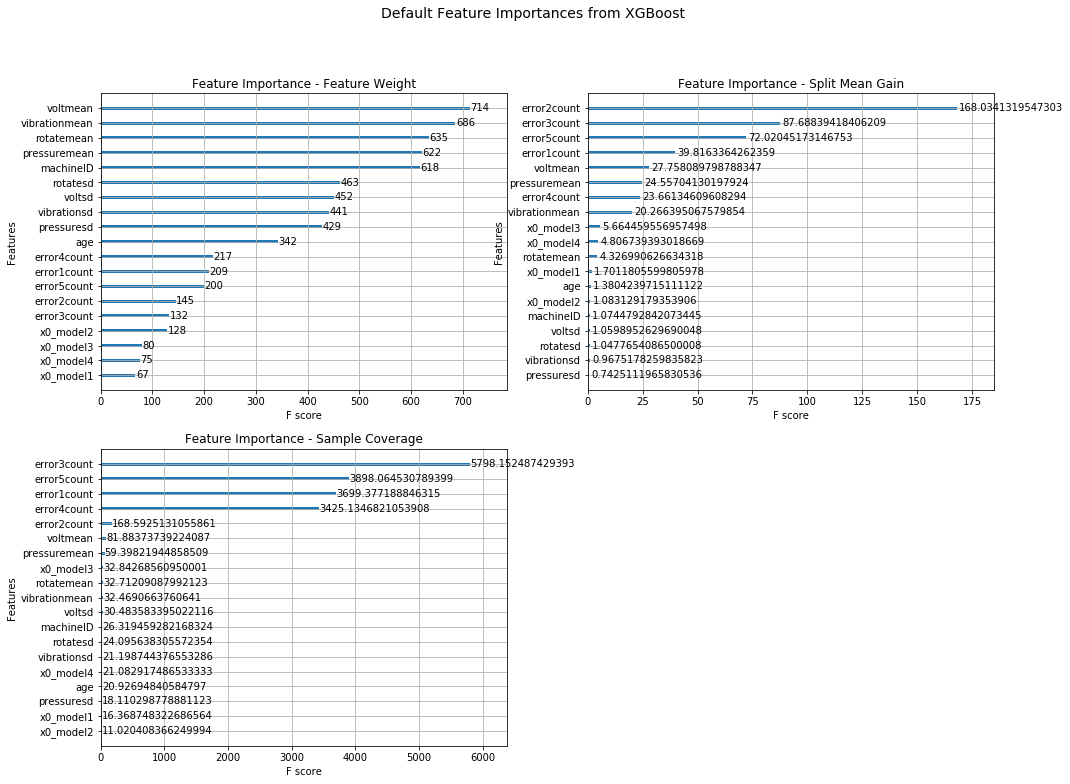

In [59]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgb_clf, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgb_clf, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgb_clf, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

### ELI5

[ELI5](https://eli5.readthedocs.io/en/latest/) is a Python package which helps to debug machine learning classifiers and explain their predictions.

In [60]:
import eli5

#### Feature Importance

Typically for tree-based models ELI5 does nothing special but uses the out-of-the-box feature importance computation methods which we discussed in the previous section. By default, **'gain'** is used, that is the average gain of the feature when it is used in trees.

In [61]:
eli5.show_weights(xgb_clf.get_booster())

Weight,Feature
0.3446,error2count
0.1798,error3count
0.1477,error5count
0.0816,error1count
0.0569,voltmean
0.0504,pressuremean
0.0485,error4count
0.0416,vibrationmean
0.0116,x0_model3
0.0099,x0_model4


#### Explaining model predictions by individual observation

Weight means how much each feature contributed to the final prediction across all trees. The idea for weight calculation is described in http://blog.datadive.net/interpreting-random-forests/; eli5 provides an independent implementation of this algorithm for XGBoost and most scikit-learn tree ensembles.

In [62]:
row_no = 0
print('Actual Label:', y_test.iloc[row_no])
print('Predicted Label:', y_pred[row_no])
eli5.show_prediction(xgb_clf.get_booster(), X_test_pre.iloc[row_no], 
                     feature_names=list(X_train_pre.columns) ,show_feature_values=True)

Actual Label: False
Predicted Label: False


In [63]:
row_no = 9
print('Actual Label:', y_test.iloc[row_no])
print('Predicted Label:', y_pred[row_no])
eli5.show_prediction(xgb_clf.get_booster(), X_test_pre.iloc[row_no], 
                     feature_names=list(X_train_pre.columns) ,show_feature_values=True)

Actual Label: True
Predicted Label: True


### SHAP

In [2]:
from numpy.lib.arraypad import _validate_length

ImportError: cannot import name '_validate_length' from 'numpy.lib.arraypad' (C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraypad.py)

In [1]:
import shap
shap.initjs()

ImportError: cannot import name '_validate_lengths' from 'numpy.lib.arraypad' (C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraypad.py)